In [1]:
%matplotlib inline
from __future__ import division
from pandas import Series, DataFrame
import pandas as pd
from numpy.random import randn
import numpy as np
# pd.options.display.max_rows = 12
np.set_printoptions(precision=4, suppress=True)
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(12, 4))
pd.set_option('display.max_columns', None) #输出所有列

def set_ch():
    from pylab import mpl
    #中文字体问题已经解决，记录在evernote中
    #mpl.rcParams['font.sans-serif'] = ['SimHei'] # 指定默认字体
    mpl.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题
set_ch()
from datetime import datetime,timedelta
import matplotlib
matplotlib.style.use('ggplot')
import sys
import json
import seaborn as sns

In [2]:
# import data
df_up = pd.read_csv('data/index_up.csv')
df_middle = pd.read_csv('data/index_mid.csv')
df_down = pd.read_csv('data/index_down.csv')

df_all = pd.concat([df_down, df_middle, df_up], axis=0).reset_index().drop(['index'], axis=1)
df_all.head(3)

,stu_id,visa_typ_cd,usr_visa_strt_tm,usr_visa_end_tm,group,min_time,par_days,actual_day,sub_tol,sub_avg,sub_avg_a,ex_tol,ex_subrate,sub_ins_sd,sub_ins_m,ins_sd,ins_m,auc_sub_avg,auc_sub_sd,ins_min,ins_four_1,ins_four_2,ins_four_3,ins_max,ins_summit_min,ins_summit_four_1,ins_summit_four_2,ins_summit_four_3,ins_summit_max,0point_sub,1point_sub,2point_sub,3point_sub,4point_sub,5point_sub,6point_sub,7point_sub,8point_sub,9point_sub,10point_sub,11point_sub,12point_sub,13point_sub,14point_sub,15point_sub,16point_sub,17point_sub,18point_sub,19point_sub,20point_sub,21point_sub,22point_sub,23point_sub,0point_ex,1point_ex,2point_ex,3point_ex,4point_ex,5point_ex,6point_ex,7point_ex,8point_ex,9point_ex,10point_ex,11point_ex,12point_ex,13point_ex,14point_ex,15point_ex,16point_ex,17point_ex,18point_ex,19point_ex,20point_ex,21point_ex,22point_ex,23point_ex,notscWe_sub,notscWe_ex,notscWd_sub,notscWd_ex,sc_sub,sc_ex,pub_avg,pub_sd,n_ex,n_pkg,n_pra_ex_avg,n_pra_ex_sd,y,top_schl_id,school
0,64005,A,2016-06-19 00:00:00,2016-12-19 23:59:59,1625.0,2016-06-19 09:18:16,91.999994,16,89,0.967391,5.562500,509,0.647926,269.284575,179.550562,6.432251,2.033708,97.156679,8.085544,0,0.0,0.0,0.0,43,0,25.00,102.0,201.00,1562,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,5,62,18,2,0,0,0,0,0,0,0,0,0,0,12,0,0,0,0,0,0,0,0,0,19,366,97,15,0,44.0,248.0,3.0,13.0,42.0,248.0,4.122255,2.054635,391,25,1.30179,0.604235,1.0,432590.0,down
1,64005,A1,2016-12-24 00:00:00,2017-06-24 23:59:59,1626.0,2016-12-24 20:21:05,91.499994,18,180,1.967213,10.000000,1032,0.538399,145.235432,128.694444,3.940904,1.000000,98.138889,9.697912,0,0.0,0.0,0.0,25,0,67.75,101.0,156.25,1427,0,0,0,0,0,0,0,0,4,0,0,0,0,0,10,3,0,0,0,73,63,27,0,0,0,0,0,0,0,0,0,0,20,0,0,0,0,0,60,9,0,0,0,424,356,163,0,0,18.0,95.0,120.0,693.0,42.0,244.0,2.796135,1.737008,501,28,2.05988,0.977961,1.0,436223.0,down
2,64005,A1,2017-07-01 00:00:00,2017-12-03 22:06:52,2092.0,2017-07-01 21:03:18,77.960718,11,138,1.770122,12.545455,868,0.642373,51.065638,80.702899,4.442761,0.920290,99.359903,3.725814,0,0.0,0.0,0.0,32,0,56.00,72.5,102.50,387,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12,8,4,87,20,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,70,54,24,570,102,48,0,38.0,255.0,48.0,287.0,52.0,326.0,2.766655,1.802080,602,32,1.44186,0.776597,1.0,434410.0,down


In [3]:
# filtering the meaningless columns
df_all = df_all.drop(['ins_sd', 'ins_four_1', 'ins_four_2','ins_four_3','ins_min', 'ins_summit_min'],axis=1)

In [4]:
# finding the the columns including NAN
def findingNAN(df):
    colNaN = [col for col in df.columns.values if df[col].isnull().any()==True]
    return colNaN

# filling the NAN upon the suggestion of sara
def filling(df, col_li):
    df['pub_avg'] = df.pub_avg.fillna(df.pub_avg.mean(skipna=True))
    col_li.remove('pub_avg')
    for col in col_li:
        df[col] = df[col].fillna(0)
    return df

# findingNAN——>filling——>standardization
from sklearn import preprocessing
def processing(df):
    col_toBeFill = findingNAN(df)
    filled = filling(df, col_toBeFill)
    
    X = filled.iloc[:,6:-3].values
    scaler = preprocessing.StandardScaler().fit(X)
    X_sd = scaler.transform(X)
    df_sd = pd.DataFrame(X_sd)
    df_sd.columns = df.iloc[:, 6:-3].columns.values
    return df_sd

In [5]:
df_X = processing(df_all)

In [6]:
df_all.y.value_counts()

1.0    379739
0.0     50819
Name: y, dtype: int64

# LogisticRegression

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import KFold,cross_val_score
from sklearn.metrics import confusion_matrix,recall_score,classification_report,f1_score
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import  GridSearchCV

/Applications/anaconda/envs/py27/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [8]:
# define the X & y
X = df_X.values
y = df_all.y.values

In [16]:
# cross validation
from sklearn.cross_validation import KFold,cross_val_score
scores = cross_val_score(estimator=LogisticRegression(penalty='l1'), 
                         X=X, y=y, cv=5, n_jobs=1, scoring="f1")
print('CV f1: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV f1: 0.926 +/- 0.019


In [12]:
# logistic regression
def LR(X,y):
    X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.3, random_state=0)

    lr = LogisticRegression(penalty = 'l1')
    print ('training...')
    lr.fit(X_train,Y_train)
    Y_pred = lr.predict(X_test)
    print ('predict finished')

    # Compute confusion matrix
    cnf_matrix = confusion_matrix(Y_test,Y_pred)
    F1 = f1_score(Y_test, Y_pred)
    
    
    return (Y_pred, lr, cnf_matrix, F1)

In [13]:
y_pred, lr, cnf_matrix, F1 = LR(X,y)

training...
predict finished


In [169]:
cnf_matrix

array([[  2545,  12753],
       [  1659, 112211]])

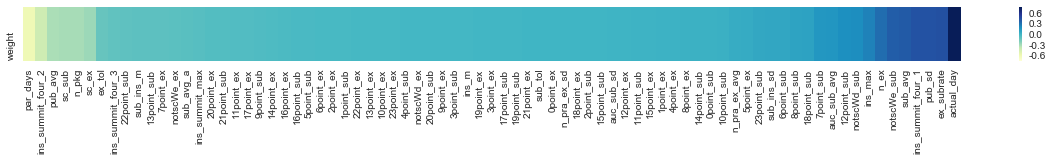

In [16]:
df_weight = pd.DataFrame(lr.coef_.T)
df_weight.index = df_X.columns.values
df_weight.columns = ['weight']

# plot weight
plt.rc('figure', figsize=(21, 1))
sns.heatmap(df_weight.sort_values(by=['weight']).T,cmap="YlGnBu")

In [17]:
df_weight.sort_values(by=['weight']).T

,par_days,ins_summit_four_2,pub_avg,sc_sub,n_pkg,sc_ex,ex_tol,ins_summit_four_3,22point_sub,sub_ins_m,13point_sub,7point_ex,notscWe_ex,sub_avg_a,ins_summit_max,20point_ex,21point_sub,11point_ex,17point_ex,9point_sub,14point_ex,16point_ex,16point_sub,5point_sub,6point_ex,2point_ex,1point_sub,22point_ex,13point_ex,10point_ex,23point_ex,4point_sub,notscWd_ex,20point_sub,9point_ex,3point_sub,ins_m,19point_ex,3point_ex,17point_sub,19point_sub,21point_ex,sub_tol,0point_ex,n_pra_ex_sd,18point_ex,2point_sub,15point_sub,auc_sub_sd,12point_ex,11point_sub,15point_ex,1point_ex,4point_ex,8point_ex,14point_sub,0point_sub,10point_sub,n_pra_ex_avg,5point_ex,23point_sub,sub_ins_sd,6point_sub,8point_sub,18point_sub,7point_sub,auc_sub_avg,12point_sub,notscWd_sub,ins_max,n_ex,notscWe_sub,sub_avg,ins_summit_four_1,pub_sd,ex_subrate,actual_day
weight,-0.5956,-0.412164,-0.305776,-0.295123,-0.293231,-0.265238,-0.11834,-0.100997,-0.091827,-0.088361,-0.086369,-0.085434,-0.082354,-0.072804,-0.066858,-0.055595,-0.055346,-0.049909,-0.047918,-0.042092,-0.036179,-0.033392,-0.028209,-0.028025,-0.02378,-0.020244,-0.018573,-0.014449,-0.014068,-0.012891,-0.011971,-0.010966,-0.010733,-0.010695,-0.010443,-0.009984,-0.007798,-0.005297,-0.004214,-0.001181,-0.001048,0.0,0.0,0.002559,0.002654,0.004269,0.005078,0.005304,0.006107,0.011294,0.01306,0.015922,0.020641,0.02217,0.024399,0.025297,0.025881,0.030911,0.048237,0.057677,0.072052,0.080369,0.083254,0.097674,0.105395,0.16084,0.162691,0.195197,0.199294,0.247696,0.322973,0.38458,0.397735,0.432329,0.435145,0.441395,0.763247


基于LR结果可以发现在一下续费率与这几个方面有比较高的权重[abs(weight) > 0.4]：    

负向        
* 购买套餐后实际经过了多久开始做题(-0.596) ;   
* 两次提交的时间间隔的中位数（-0.412）

正向     
* 实际的做作业天数(0.763)；      
* 每次提交的做题数量(0.441)；     
* 自老师布置作业后隔多久学生会去做题（0.435）；  
* 两次提交的时间间隔的下四分位数(0.432)；   


总结：
1. 做作业时间更久(actual_day)、每次提交中做题数(ex_subrate)更多的学生更容易续费——**投入时间：投入时间越多的越容易续费**
2. 自老师布置作业后隔多久去做题的方差(pub_sd)，方差越大（波动越大）的学生更容易续费——**做题习惯（出乎意料的）：做题不规律的越容易续费**
2. 两次提交时间间隔的中位数，越小越容易续费(ins_summit_four_2)；两次提交时间间隔的下四分位数(ins_summit_four_1)，越大越容易续费——**做题的频繁程度：做题越频繁越容易续费**
3. 购买套餐后实际经过了多久开始做题(par_days)——**唤醒时间：唤醒时间越短的越容易续费**

In [18]:
# calculate probability
_ = np.sum(X * lr.coef_, axis=1) + lr.intercept_
df_X['wTx'] = _
df_X['probability'] = 1.0 / (1.0  + np.exp(-_))

In [19]:
# lable the student
lable_li = []
for i in range(len(df_X)):
    if df_X.probability[i] < 0.03:
        lable_li.append('0')
    elif df_X.probability[i] > 0.97:
        lable_li.append('1')
    else:
        lable_li.append('0.5')
        
df_X['lable'] = lable_li

In [20]:
df_X.head(3)

,par_days,actual_day,sub_tol,sub_avg,sub_avg_a,ex_tol,ex_subrate,sub_ins_sd,sub_ins_m,ins_m,auc_sub_avg,auc_sub_sd,ins_max,ins_summit_four_1,ins_summit_four_2,ins_summit_four_3,ins_summit_max,0point_sub,1point_sub,2point_sub,3point_sub,4point_sub,5point_sub,6point_sub,7point_sub,8point_sub,9point_sub,10point_sub,11point_sub,12point_sub,13point_sub,14point_sub,15point_sub,16point_sub,17point_sub,18point_sub,19point_sub,20point_sub,21point_sub,22point_sub,23point_sub,0point_ex,1point_ex,2point_ex,3point_ex,4point_ex,5point_ex,6point_ex,7point_ex,8point_ex,9point_ex,10point_ex,11point_ex,12point_ex,13point_ex,14point_ex,15point_ex,16point_ex,17point_ex,18point_ex,19point_ex,20point_ex,21point_ex,22point_ex,23point_ex,notscWe_sub,notscWe_ex,notscWd_sub,notscWd_ex,sc_sub,sc_ex,pub_avg,pub_sd,n_ex,n_pkg,n_pra_ex_avg,n_pra_ex_sd,wTx,probability,lable
0,-0.033105,-0.395936,-0.644595,-0.555651,-0.817037,-0.562050,-0.361577,-0.786224,-0.382721,0.927806,0.674563,-1.009992,0.657964,-0.125647,0.203577,0.070859,-0.971936,-0.075992,-0.053286,-0.055738,-0.046149,-0.048629,-0.063615,-0.187862,-0.324343,-0.403366,-0.359561,-0.430731,-0.499435,-0.441617,-0.498844,-0.447117,-0.467167,-0.516747,-0.581672,-0.648357,-0.606850,0.674575,-0.079822,-0.285639,-0.189026,-0.060439,-0.044523,-0.051493,-0.038266,-0.03656,-0.023851,-0.127444,-0.308602,-0.379567,-0.327445,-0.438014,-0.491019,-0.443529,-0.491139,-0.451035,-0.460430,-0.517613,-0.574557,-0.636855,-0.615074,0.762360,-0.075576,-0.223672,-0.183007,-0.453688,-0.400729,-0.730534,-0.668128,-0.355483,-0.274871,1.580239,0.988537,-0.588667,-0.350654,-0.141557,-0.040689,1.800955,0.858265,0.5
1,-0.041788,-0.305485,-0.259384,-0.284462,-0.008800,-0.169420,-0.888529,-0.866597,-0.518167,0.117913,0.766139,-0.840865,-0.068787,0.828026,0.193523,-0.089811,-0.980802,-0.075992,-0.053286,-0.055738,-0.046149,-0.048629,-0.063615,-0.187862,-0.324343,-0.159331,-0.464483,-0.430731,-0.499435,-0.441617,-0.498844,-0.025307,-0.340401,-0.516747,-0.581672,-0.648357,0.937627,0.697380,0.194237,-0.406556,-0.189026,-0.060439,-0.044523,-0.051493,-0.038266,-0.03656,-0.023851,-0.127444,-0.308602,-0.155319,-0.441771,-0.438014,-0.491019,-0.443529,-0.491139,0.046445,-0.388044,-0.517613,-0.574557,-0.636855,1.084464,0.722600,0.275399,-0.388228,-0.183007,-0.709329,-0.690020,0.481738,0.522135,-0.355483,-0.281963,0.599517,0.608781,-0.469376,-0.262647,0.893833,0.280989,2.299569,0.908841,0.5
2,-0.276903,-0.622064,-0.437174,-0.337920,0.454823,-0.292539,-0.388290,-0.927611,-0.645983,0.055462,0.879979,-1.467298,0.213838,0.565906,-0.093004,-0.282794,-1.049103,-0.075992,-0.053286,-0.055738,-0.046149,-0.048629,-0.063615,-0.187862,-0.324343,-0.403366,-0.464483,-0.430731,-0.499435,-0.441617,-0.498844,-0.447117,-0.467167,-0.516747,-0.202820,-0.422215,-0.629563,1.244690,-0.018920,0.016656,-0.189026,-0.060439,-0.044523,-0.051493,-0.038266,-0.03656,-0.023851,-0.127444,-0.308602,-0.379567,-0.441771,-0.438014,-0.491019,-0.443529,-0.491139,-0.451035,-0.460430,-0.517613,-0.153319,-0.346346,-0.594092,1.573463,-0.048987,0.138352,-0.183007,-0.512682,-0.387494,-0.264275,-0.188522,-0.256692,-0.136580,0.577716,0.686580,-0.359846,-0.145305,0.049749,0.107669,2.244340,0.904161,0.5


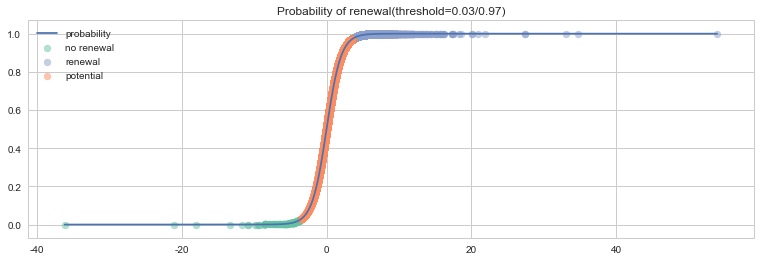

In [170]:
# plot the probability of renewal
df_sorted = DataFrame()
df_sorted['wTx'] = np.sort(np.sum(X * lr.coef_, axis=1) + lr.intercept_)
df_sorted['probability'] = 1.0 / (1.0  + np.exp(-(df_sorted.wTx)))

sns.set_style("whitegrid")
plt.rc('figure', figsize=(13, 4))
plt.plot(df_sorted.wTx, df_sorted.probability)
plt.scatter(df_sorted[df_sorted.probability<0.03].wTx, df_sorted[df_sorted.probability<0.03].probability, 
            marker='o',alpha=0.5, color=sns.color_palette("Set2", 10)[0], label='no renewal')
plt.scatter(df_sorted[df_sorted.probability>0.97].wTx, df_sorted[df_sorted.probability>0.97].probability, 
            marker='o',alpha=0.5, color=sns.color_palette("Set2", 10)[2], label='renewal')
plt.scatter(df_sorted[(df_sorted.probability>0.03)&(df_sorted.probability<0.97)].wTx, df_sorted[(df_sorted.probability>0.03)&(df_sorted.probability<0.97)].probability, 
            marker='o',alpha=0.5, color=sns.color_palette("Set2", 10)[1], label='potential')
plt.title("Probability of renewal(threshold=0.03/0.97)")
plt.legend()

In [22]:
print ('no renewal: %s' % len(df_X[df_X.lable == '0']))
print ('renewal: %s' % len(df_X[df_X.lable == '1']))
print ('potential: %s' % len(df_X[df_X.lable == '0.5']))

no renewal: 198
renewal: 103064
potential: 327296


In [164]:
[len(df_X[df_X.lable == '0'])/len(df_all[df_all.y == 0]),
len(df_X[df_X.lable == '1'])/len(df_all[df_all.y == 1])]

[0.003896180562388083, 0.2714074667073964]

### 统计3类用户在主要特征上的差异

##### ①在不同时间段内的使用量

In [24]:
df_all['lable'] = lable_li
df_all.head(3)

,stu_id,visa_typ_cd,usr_visa_strt_tm,usr_visa_end_tm,group,min_time,par_days,actual_day,sub_tol,sub_avg,sub_avg_a,ex_tol,ex_subrate,sub_ins_sd,sub_ins_m,ins_m,auc_sub_avg,auc_sub_sd,ins_max,ins_summit_four_1,ins_summit_four_2,ins_summit_four_3,ins_summit_max,0point_sub,1point_sub,2point_sub,3point_sub,4point_sub,5point_sub,6point_sub,7point_sub,8point_sub,9point_sub,10point_sub,11point_sub,12point_sub,13point_sub,14point_sub,15point_sub,16point_sub,17point_sub,18point_sub,19point_sub,20point_sub,21point_sub,22point_sub,23point_sub,0point_ex,1point_ex,2point_ex,3point_ex,4point_ex,5point_ex,6point_ex,7point_ex,8point_ex,9point_ex,10point_ex,11point_ex,12point_ex,13point_ex,14point_ex,15point_ex,16point_ex,17point_ex,18point_ex,19point_ex,20point_ex,21point_ex,22point_ex,23point_ex,notscWe_sub,notscWe_ex,notscWd_sub,notscWd_ex,sc_sub,sc_ex,pub_avg,pub_sd,n_ex,n_pkg,n_pra_ex_avg,n_pra_ex_sd,y,top_schl_id,school,lable
0,64005,A,2016-06-19 00:00:00,2016-12-19 23:59:59,1625.0,2016-06-19 09:18:16,91.999994,16,89,0.967391,5.562500,509,0.647926,269.284575,179.550562,2.033708,97.156679,8.085544,43,25.00,102.0,201.00,1562,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,5,62,18,2,0,0,0,0,0,0,0,0,0,0,12,0,0,0,0,0,0,0,0,0,19,366,97,15,0,44.0,248.0,3.0,13.0,42.0,248.0,4.122255,2.054635,391,25,1.30179,0.604235,1.0,432590.0,down,0.5
1,64005,A1,2016-12-24 00:00:00,2017-06-24 23:59:59,1626.0,2016-12-24 20:21:05,91.499994,18,180,1.967213,10.000000,1032,0.538399,145.235432,128.694444,1.000000,98.138889,9.697912,25,67.75,101.0,156.25,1427,0,0,0,0,0,0,0,0,4,0,0,0,0,0,10,3,0,0,0,73,63,27,0,0,0,0,0,0,0,0,0,0,20,0,0,0,0,0,60,9,0,0,0,424,356,163,0,0,18.0,95.0,120.0,693.0,42.0,244.0,2.796135,1.737008,501,28,2.05988,0.977961,1.0,436223.0,down,0.5
2,64005,A1,2017-07-01 00:00:00,2017-12-03 22:06:52,2092.0,2017-07-01 21:03:18,77.960718,11,138,1.770122,12.545455,868,0.642373,51.065638,80.702899,0.920290,99.359903,3.725814,32,56.00,72.5,102.50,387,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12,8,4,87,20,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,70,54,24,570,102,48,0,38.0,255.0,48.0,287.0,52.0,326.0,2.766655,1.802080,602,32,1.44186,0.776597,1.0,434410.0,down,0.5


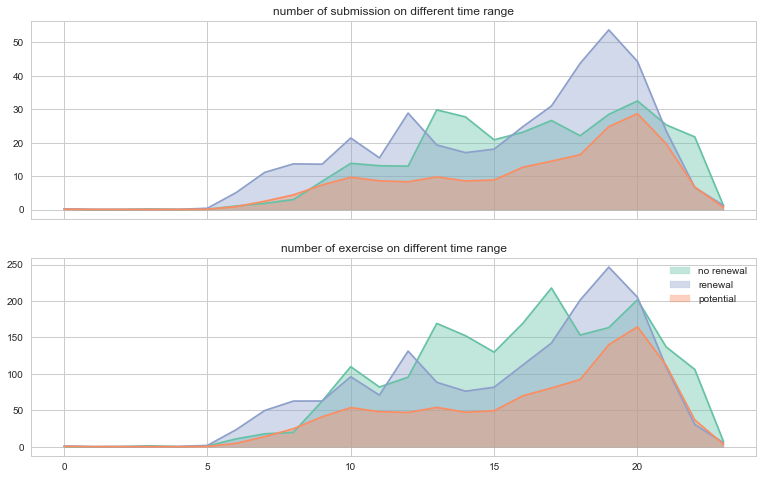

In [50]:
import seaborn as sns

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(13, 8), sharex=True)

# number of submission
ax1.plot(np.arange(0,24),df_all[df_all.lable == '0'].iloc[:,23:47].mean(axis=0),color=sns.color_palette("Set2", 10)[0])
ax1.fill_between(np.arange(0,24),df_all[df_all.lable == '0'].iloc[:,23:47].mean(axis=0),0,color=sns.color_palette("Set2", 10)[0], alpha=0.4, label='no renewal')

ax1.plot(np.arange(0,24),df_all[df_all.lable == '1'].iloc[:,23:47].mean(axis=0),color=sns.color_palette("Set2", 10)[2])
ax1.fill_between(np.arange(0,24),df_all[df_all.lable == '1'].iloc[:,23:47].mean(axis=0),0,color=sns.color_palette("Set2", 10)[2], alpha=0.4, label='renewal')

ax1.plot(np.arange(0,24),df_all[df_all.lable == '0.5'].iloc[:,23:47].mean(axis=0),color=sns.color_palette("Set2", 10)[1])
ax1.fill_between(np.arange(0,24),df_all[df_all.lable == '0.5'].iloc[:,23:47].mean(axis=0),0,color=sns.color_palette("Set2", 10)[1], alpha=0.4, label='potential')
ax1.set_title('number of submission on different time range')

# number of exercise
ax2.plot(np.arange(0,24),df_all[df_all.lable == '0'].iloc[:,47:71].mean(axis=0),color=sns.color_palette("Set2", 10)[0])
ax2.fill_between(np.arange(0,24),df_all[df_all.lable == '0'].iloc[:,47:71].mean(axis=0),0,color=sns.color_palette("Set2", 10)[0], alpha=0.4, label='no renewal')

ax2.plot(np.arange(0,24),df_all[df_all.lable == '1'].iloc[:,47:71].mean(axis=0),color=sns.color_palette("Set2", 10)[2])
ax2.fill_between(np.arange(0,24),df_all[df_all.lable == '1'].iloc[:,47:71].mean(axis=0),0,color=sns.color_palette("Set2", 10)[2], alpha=0.4, label='renewal')

ax2.plot(np.arange(0,24),df_all[df_all.lable == '0.5'].iloc[:,47:71].mean(axis=0),color=sns.color_palette("Set2", 10)[1])
ax2.fill_between(np.arange(0,24),df_all[df_all.lable == '0.5'].iloc[:,47:71].mean(axis=0),0,color=sns.color_palette("Set2", 10)[1], alpha=0.4, label='potential')
ax2.set_title('number of exercise on different time range')

plt.legend()

一个明显的差别是：
* 续费的学生做作业量大，提交数量也比较大（上下图形态基本一致）；
* 不续费的学生做作业量大，但是提交数量却相对较少（下图的做题数相对上图的提交数要多）


问题：   
* 学生在做作业的时候提交是怎样的？（一个package一次提交？）这里会不会涉及到这个提交的按钮设计的不太好等问题？

##### ②工作日，周末，寒暑假的使用情况

In [73]:
# y, renewal/not, period
df_period_sub = pd.DataFrame([[df_all[df_all.lable == '0'].notscWd_sub.mean(axis=0),'renewal', 'workDay'],
[df_all[df_all.lable == '1'].notscWd_sub.mean(axis=0),'not renewal', 'workDay'],
[df_all[df_all.lable == '0'].notscWe_sub.mean(axis=0),'renewal', 'weekend'],
[df_all[df_all.lable == '1'].notscWe_sub.mean(axis=0),'not renewal', 'weekend'],
[df_all[df_all.lable == '0'].sc_sub.mean(axis=0),'renewal', 'vacation'],
[df_all[df_all.lable == '1'].sc_sub.mean(axis=0),'not renewal', 'vacation']])
df_period_sub.columns = ['number', 'renewal/not', 'period']


df_period_ex = pd.DataFrame([[df_all[df_all.lable == '0'].notscWd_ex.mean(axis=0),'renewal', 'workDay'],
[df_all[df_all.lable == '1'].notscWd_ex.mean(axis=0),'not renewal', 'workDay'],
[df_all[df_all.lable == '0'].notscWe_ex.mean(axis=0),'renewal', 'weekend'],
[df_all[df_all.lable == '1'].notscWe_ex.mean(axis=0),'not renewal', 'weekend'],
[df_all[df_all.lable == '0'].sc_ex.mean(axis=0),'renewal', 'vacation'],
[df_all[df_all.lable == '1'].sc_ex.mean(axis=0),'not renewal', 'vacation']])
df_period_ex.columns = ['number', 'renewal/not', 'period']

In [143]:
df_period_sub

,number,renewal/not,period
0,32.651515,renewal,workDay
1,114.210258,not renewal,workDay
2,41.540404,renewal,weekend
3,164.292478,not renewal,weekend
4,278.944444,renewal,vacation
5,115.449818,not renewal,vacation


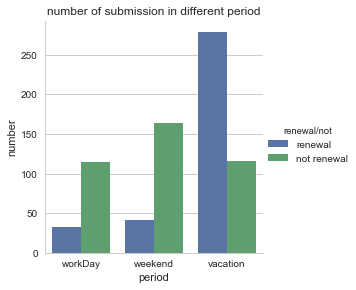

In [194]:
sns.factorplot(x='period', y='number', hue='renewal/not', data=df_period_sub, kind='bar')
plt.title('number of submission in different period')

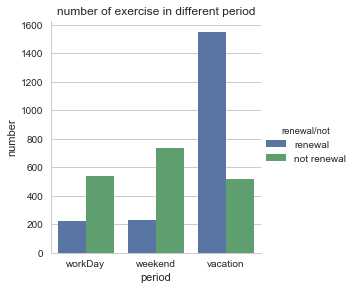

In [168]:
sns.factorplot(x='period', y='number', hue='renewal/not', data=df_period_ex, kind='bar')
plt.title('number of exercise in different period')

##### ③投入时间

In [185]:
from scipy.stats import ttest_ind
from scipy.stats import levene
def leven_ttest(x, y):
    levene_p = levene(x, y)[1]
    if levene_p > 0.05:
        # Homogeneity of variance test，the variance is equal if p>0.05
        print levene(x, y)
        # difference test，difference is extremely significant if p<0.01
        print (ttest_ind(x, y))
    else:
        print levene(x, y)
        print (ttest_ind(x, y,equal_var=False))

In [186]:
# 做题天数
print ([df_all[df_all.lable == '0'].actual_day.mean(axis=0), df_all[df_all.lable == '1'].actual_day.mean(axis=0)])
leven_ttest(df_all[df_all.lable == '0'].actual_day, df_all[df_all.lable == '1'].actual_day)

[19.31313131313131, 41.37244818753396]
LeveneResult(statistic=0.39395498687109576, pvalue=0.53022917239379397)
Ttest_indResult(statistic=-10.945047679270854, pvalue=7.2702020976127052e-28)


In [187]:
# 每次提交中的做题数
print ([df_all[df_all.lable == '0'].ex_subrate.mean(axis=0), df_all[df_all.lable == '1'].ex_subrate.mean(axis=0)])
leven_ttest(df_all[df_all.lable == '0'].ex_subrate, df_all[df_all.lable == '1'].ex_subrate)

[0.6080432929661489, 0.8080816910934565]
LeveneResult(statistic=245.04115862836761, pvalue=3.6232925732061924e-55)
Ttest_indResult(statistic=-10.583898483367022, pvalue=5.1033577459479075e-21)


##### ④做题习惯

In [188]:
print ([df_all[df_all.lable == '0'].pub_sd.mean(axis=0),df_all[df_all.lable == '1'].pub_sd.mean(axis=0)])
leven_ttest(df_all[df_all.lable == '0'].pub_sd, df_all[df_all.lable == '1'].pub_sd)

[0.21567830791589257, 1.3784046458728352]
LeveneResult(statistic=119.17669178439432, pvalue=9.9210100317364902e-28)
Ttest_indResult(statistic=-30.069868277867439, pvalue=8.9441201937053731e-76)


##### ⑤做题的频繁程度

In [189]:
print ([df_all[df_all.lable == '0'].ins_summit_four_1.mean(axis=0),
        df_all[df_all.lable == '1'].ins_summit_four_1.mean(axis=0)])
leven_ttest(df_all[df_all.lable == '0'].ins_summit_four_1, df_all[df_all.lable == '1'].ins_summit_four_1)

[25.707070707070706, 30.07932934875417]
LeveneResult(statistic=398.29791106941593, pvalue=1.8996426090358844e-88)
Ttest_indResult(statistic=-0.65841258453133722, pvalue=0.51104171906088491)


In [190]:
print ([df_all[df_all.lable == '0'].ins_summit_four_2.mean(axis=0), 
        df_all[df_all.lable == '1'].ins_summit_four_2.mean(axis=0)])
leven_ttest(df_all[df_all.lable == '0'].ins_summit_four_2, df_all[df_all.lable == '1'].ins_summit_four_2)

[606.8787878787879, 57.26563591554762]
LeveneResult(statistic=77160.069521505618, pvalue=0.0)
Ttest_indResult(statistic=12.186593530342487, pvalue=7.9579164013802365e-26)


##### ⑥唤醒时间

In [191]:
print ([df_all[df_all.lable == '0'].par_days.mean(axis=0),
        df_all[df_all.lable == '1'].par_days.mean(axis=0)])
leven_ttest(df_all[df_all.lable == '0'].par_days, df_all[df_all.lable == '1'].par_days)

[145.108478856855, 97.18303544407895]
LeveneResult(statistic=259.91325345284355, pvalue=2.1129144446270509e-58)
Ttest_indResult(statistic=4.1257036491523706, pvalue=5.4491864843942355e-05)


##### ⑦分数

In [192]:
print ([df_all[df_all.lable == '0'].auc_sub_avg.mean(axis=0),
 df_all[df_all.lable == '1'].auc_sub_avg.mean(axis=0)])
leven_ttest(df_all[df_all.lable == '0'].auc_sub_avg, df_all[df_all.lable == '1'].auc_sub_avg)

[83.7393389413701, 93.0837731687023]
LeveneResult(statistic=431.92311144034983, pvalue=9.7463680702149315e-96)
Ttest_indResult(statistic=-7.9293393450798773, pvalue=1.6056494325043605e-13)
